<a href="https://colab.research.google.com/github/Magellol/aqi-predictions/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The accuracy is shit so here some things to try:
- [ ] More data?
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Normalize the target label (keep it between 0 and 1)


Compare results with https://aqicn.org/city/montreal/

In [44]:
import pandas as pd
from fastai.tabular.all import *

# Data is from Jan 2022 -> April 2024
df1 = pd.read_csv('./rsqa-indice-qualite-air-2019-2021.csv')
df2 = pd.read_csv('./rsqa-indice-qualite-air-2022-2024.csv')

In [121]:
def aggregate_aqi(df):
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
  # Asserting to make sure data doesn't have missing date
  assert df.datetime.isnull().sum() == 0, 'missing dates'

  df.drop(["heure", "date", "polluant"], axis=1, inplace=True)
  # the data contains measurements across various stations (spread over the MTL territory).
  # Setting the index on both stationId and datetime lets us take the maximum measurement a station id has gotten for a given datetime across pollutants
  # Note: we are assuming each pollutant contributes equally to the AQI level
  # (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
  aqi_df= df.groupby(['stationId', 'datetime']).max()

  # Now calculate the mean of these maximum values across all stations for each datetime
  general_aqi_df = aqi_df.groupby('datetime').mean()

  # general_aqi_df.set_index(['datetime'], inplace=True)
  # general_aqi_df.drop(["stationId"], axis=1, inplace=True)
  return general_aqi_df


In [125]:
df = pd.concat([df1, df2])

general_aqi = aggregate_aqi(df)

general_aqi['year'] = general_aqi.index.year
general_aqi['month'] = general_aqi.index.month
general_aqi['day'] = general_aqi.index.day
general_aqi['weekday'] = general_aqi.index.weekday
general_aqi['hour'] = general_aqi.index.hour

general_aqi



,valeur,year,month,day,weekday,hour
datetime,,,,,,
2019-01-01 00:00:00,33.454545,2019,1,1,1,0
2019-01-01 01:00:00,28.181818,2019,1,1,1,1
2019-01-01 02:00:00,19.363636,2019,1,1,1,2
2019-01-01 03:00:00,13.454545,2019,1,1,1,3
2019-01-01 04:00:00,10.909091,2019,1,1,1,4
...,...,...,...,...,...,...
2024-04-11 19:00:00,19.272727,2024,4,11,3,19
2024-04-11 20:00:00,19.636364,2024,4,11,3,20
2024-04-11 21:00:00,19.454545,2024,4,11,3,21


In [136]:
split_date_valid = pd.Timestamp('2022-01-01')
split_date_test = pd.Timestamp('2023-01-01')

train_idx = general_aqi.index < split_date_valid
valid_idx = (general_aqi.index >= split_date_valid) & (general_aqi.index < split_date_test)
test_idx = general_aqi.index >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

In [153]:
dls = TabularPandas(
  general_aqi.reset_index(),
  procs=[Normalize],
  cat_names=[],
  cont_names=['year', 'month', 'day', 'weekday', 'hour'],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs),
  y_block=RegressionBlock()
).dataloaders(bs=250)

dls.show_batch()

,year,month,day,weekday,hour,valeur
0,2019.0,12.0,12.000000,3.000000e+00,18.0,13.090909
1,2021.0,10.0,18.000000,-9.876598e-08,16.0,7.000000
2,2020.0,4.0,25.000000,5.000000e+00,18.0,25.545454
3,2020.0,12.0,29.999999,2.000000e+00,8.0,7.909091
4,2021.0,12.0,18.000000,5.000000e+00,17.0,17.454546
5,2020.0,3.0,5.000000,3.000000e+00,18.0,16.636364
6,2020.0,10.0,5.000000,-9.876598e-08,19.0,11.090909
7,2020.0,2.0,27.999999,4.000000e+00,9.0,16.545454
8,2020.0,5.0,12.000000,1.000000e+00,20.0,17.727272
9,2020.0,3.0,5.000000,3.000000e+00,7.0,11.545455


In [158]:
learn = tabular_learner(dls, metrics=mse, layers=[100, 100])

SuggestedLRs(valley=0.02290867641568184, slide=6.309573450380412e-07)

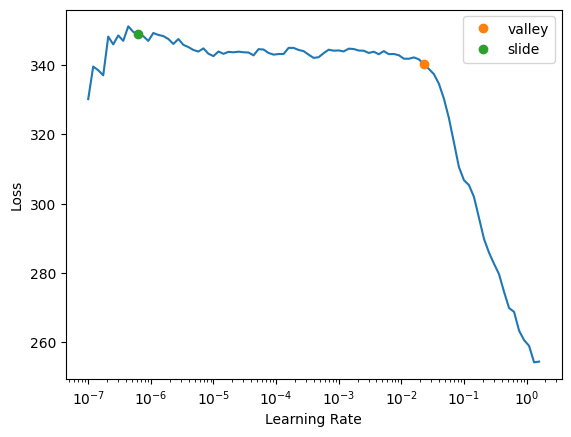

In [155]:
learn.lr_find(suggest_funcs=[valley, slide])

In [159]:
learn.fit_one_cycle(5, 0.001)

epoch,train_loss,valid_loss,mse,time
0,333.063385,299.421204,299.421204,00:01
1,259.890961,177.368484,177.368484,00:01
2,144.869766,91.239922,91.239922,00:01
3,83.048912,60.498188,60.498188,00:01
4,65.379723,57.213341,57.213341,00:01


In [151]:
# learn.recorder.plot_loss()
learn.show_results(max_n=10)

,year,month,day,weekday,hour,valeur,valeur_pred
0,2.450608,-1.021140,1.393798,-1.500801,0.072232,8.818182,22.893433
1,2.450608,1.298382,-1.105812,1.502628,-1.227936,15.545455,14.593970
2,2.450608,0.718502,-0.878575,0.000913,-0.216695,14.272727,19.336012
3,2.450608,1.588322,-0.424100,-1.500801,-0.216695,13.000000,13.196031
4,2.450608,-0.441259,-0.424100,0.000913,0.650084,31.454546,23.635834
5,2.450608,-0.731200,0.598468,0.000913,1.516862,19.818182,21.799116
6,2.450608,-1.021140,1.734654,0.000913,-0.072232,16.727272,19.748865
7,2.450608,-0.731200,0.598468,0.000913,0.216695,19.454546,22.206263
8,2.450608,-1.601020,-0.424100,-0.499658,-0.072232,23.909090,19.325527
9,2.450608,1.298382,-1.560287,-0.499658,-0.650084,16.363636,14.724465
